In [66]:
# import library yang dibutuhkan
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [67]:
# load dataset dan buat dataframe
dataframe = pd.read_csv('PK COVID-19-3jun.csv')
dataframe

,Date,Cases,Deaths,Recovered,Travel_history,Province,City
0,2/26/2020,1,0,0,China,Islamabad Capital Territory,Islamabad
1,2/26/2020,2,0,0,Iran/Taftan,Sindh,Karachi
2,2/29/2020,1,0,0,China,Islamabad Capital Territory,Islamabad
3,2/29/2020,1,0,0,Iran/Taftan,Sindh,Karachi
4,3/2/2020,1,0,0,Iran/Taftan,Gilgit-Baltistan,Gilgit
...,...,...,...,...,...,...,...
2793,5/30/2020,952,36,394,NaN,Punjab,Lahore
2794,5/31/2020,1184,22,120,NaN,Punjab,Lahore
2795,6/1/2020,1610,43,95,NaN,Punjab,Lahore
2796,6/2/2020,1639,30,353,NaN,Punjab,Lahore


In [68]:
# cek apa ada value yang hilang
dataframe.isnull().sum()

Date               0
Cases              0
Deaths             0
Recovered          0
Travel_history    36
Province           0
City               0
dtype: int64

In [69]:
# cek minimum mae
minimumMae = (dataframe['Cases'].max() - dataframe['Cases'].min()) * 10/100
minimumMae

163.9

In [70]:
# normalization dengan minmaxscaler
minmaxscaler = MinMaxScaler(feature_range = (0,1))
scaled = minmaxscaler.fit_transform(dataframe[['Cases']])
dataframe[['Cases']] = scaled

In [73]:
# mengubah ke bentuk numpy array
date = dataframe['Date'].values
cases  = dataframe['Cases'].astype("float32").values

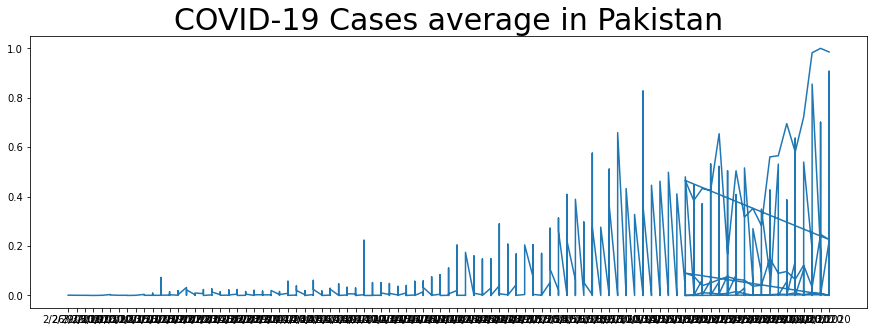

In [81]:
# viisualisasi data
plt.figure(figsize=(15,5))
plt.plot(date, cases)
plt.title('COVID-19 Cases average in Pakistan', fontsize=30);

In [82]:
# menerima attribute yg sudah diconvert ke numpy array serta return ke bentuk batch
def datasetWindowed(series, window_size, batch_size, shuffle_buffer) :
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [83]:
# model sequential
train = datasetWindowed(cases, window_size=60, batch_size=128, shuffle_buffer=1000)
model = tf.keras.models.Sequential([tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    ])

In [84]:
# menggunakan loss Huber, optimizer SGD dengan learning rate 1.0000e-02 dan momentum 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-02, momentum=0.9)

# compile
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

In [85]:
# menggunakan callback agar pengujian berhenti jika mae mencapai target
class callback(tf.keras.callbacks.Callback) :
  def on_epoch_end(self, epoch, logs={}) :
    if(logs.get('mae') < 0.1) :
      self.model.stop_training = True

In [86]:
# train model dengan fit
model.fit(train, epochs=100, callbacks=callback())

Epoch 1/100
22/22 [==============================] - 8s 141ms/step - loss: 0.0034 - mae: 0.0237
